In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import spacy
from spacy.tokens import Token
from spacy.lang.en.stop_words import STOP_WORDS
from nltk.corpus import gutenberg, stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from collections import Counter

In [2]:
# Utility function for standard text cleaning
def text_cleaner(text):
    # Visual inspection identifies a form of punctuation spaCy does not
    # recognize: the double dash '--'. 
    text = re.sub(r'--',' ',text)
    # get rid of text between brackets
    text = re.sub("[\[].*?[\]]", "", text)
    
    # Get rid of extra whitespace
    text = ' '.join(text.split())
    return text

In [3]:
milton = gutenberg.raw('milton-paradise.txt')
chesterton = gutenberg.raw('chesterton-brown.txt')

# Chapters are book specific
# Need to clear chapters before runnign clean text
chesterton = re.sub('[IVX][IVX]*\. *The.*', '', chesterton)
milton = re.sub(r'Book .*', '', milton)

milton_clean = text_cleaner(milton)
chesterton_clean = text_cleaner(chesterton)


In [4]:
# Parse the cleaned novels. 
nlp = spacy.load('en')
chesterton_doc = nlp(chesterton_clean)
milton_doc = nlp(milton_clean)

In [40]:
# Group into sentences
chesterton_sents = [[sent, 'Chesterton'] for sent in chesterton_doc.sents]
milton_sents = [[sent, 'Milton'] for sent in milton_doc.sents]

# Combine the setnences from the two novels into one data frame
sentences = pd.DataFrame(chesterton_sents + milton_sents)
sentences.columns = ['text_sentences', 'author']
sentences.head()

both_sents = [' '.join([token.lemma_ for token in sent]) for sent in sentences['text_sentences']]

both_pos = [' '.join([token.pos_ for token in sent]) for sent in sentences['text_sentences']]

In [7]:
both_sents[0:5]

['the consulting - room of dr orion hood , the eminent criminologist and specialist in certain moral disorder , lie along the sea - front at scarborough , in a series of very large and well - light french window , which show the north sea like one endless outer wall of blue - green marble .',
 'in such a place the sea have something of the monotony of a blue - green dado : for the chamber -PRON- be rule throughout by a terrible tidiness not unlike the terrible tidiness of the sea .',
 "-PRON- must not be suppose that dr hood 's apartment exclude luxury , or even poetry .",
 'these thing be there , in -PRON- place ; but one feel that -PRON- be never allow out of -PRON- place .',
 'luxury be there : there stand upon a special table eight or ten box of the good cigar ; but -PRON- be build upon a plan so that the strong be always nearest the wall and the mildest nearest the window .']

In [41]:
both_pos[0:5]

['DET NOUN PUNCT NOUN ADP PROPN PROPN PROPN PUNCT DET ADJ NOUN CCONJ NOUN ADP ADJ ADJ NOUN PUNCT VERB ADP DET NOUN PUNCT NOUN ADP PROPN PUNCT ADP DET NOUN ADP ADV ADJ CCONJ ADV PUNCT VERB ADJ NOUN PUNCT ADJ VERB DET PROPN PROPN ADP NUM ADJ ADJ NOUN ADP ADJ PUNCT ADJ NOUN PUNCT',
 'ADP ADJ DET NOUN DET NOUN VERB NOUN ADP DET NOUN ADP DET ADJ PUNCT ADJ NOUN PUNCT ADP DET NOUN PRON VERB VERB ADP ADP DET ADJ NOUN ADV ADP DET ADJ NOUN ADP DET NOUN PUNCT',
 'PRON VERB ADV VERB VERB ADP PROPN PROPN PART NOUN VERB NOUN PUNCT CCONJ ADV NOUN PUNCT',
 'DET NOUN VERB ADV PUNCT ADP ADJ NOUN PUNCT CCONJ NUM VERB ADP PRON VERB ADV VERB ADP ADP ADJ NOUN PUNCT',
 'PROPN VERB ADV PUNCT ADV VERB ADP DET ADJ NOUN NUM CCONJ NUM NOUN ADP DET ADJ NOUN PUNCT CCONJ PRON VERB VERB ADP DET NOUN ADP ADP DET ADJ VERB ADV ADP DET NOUN CCONJ DET NOUN ADP DET NOUN PUNCT']

In [8]:
# Add function to make stop words case insensitive
stop_words_getter = lambda token: token.is_stop or token.lower_ in STOP_WORDS 
Token.set_extension('is_stop', getter=stop_words_getter)

In [45]:
vectorizer = CountVectorizer(max_features=2000, min_df=10, stop_words=STOP_WORDS)
X = vectorizer.fit_transform(both_sents)
print(vectorizer.get_feature_names()[0:20])
print(X.toarray())  


['able', 'abruptly', 'absence', 'absent', 'abyss', 'accept', 'accord', 'account', 'accuse', 'achieve', 'act', 'action', 'actor', 'adam', 'add', 'address', 'admiral', 'admiration', 'admire', 'admit']
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [46]:
X

<6465x1429 sparse matrix of type '<class 'numpy.int64'>'
	with 50961 stored elements in Compressed Sparse Row format>

In [47]:
vectorizer_pos = CountVectorizer(max_features=200)
X_pos = vectorizer_pos.fit_transform(both_pos)
print(vectorizer_pos.get_feature_names())


['adj', 'adp', 'adv', 'cconj', 'det', 'intj', 'noun', 'num', 'part', 'pron', 'propn', 'punct', 'sym', 'verb']


# Random Forest Classifier

In [13]:
rfc = RandomForestClassifier(n_estimators=10)
Y = sentences['author']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    Y, 
                                                    test_size=0.4, 
                                                    random_state=0)

train = rfc.fit(X_train, y_train)

print('Training set score:', rfc.score(X_train, y_train))
print('\nTest set score:', rfc.score(X_test, y_test))

Training set score: 0.9832431038927558

Test set score: 0.8623356535189481


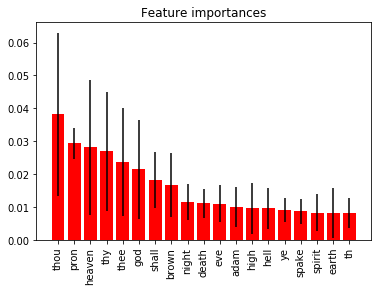

In [14]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[:-20:-1]


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), np.array(vectorizer.get_feature_names())[indices],
          rotation='vertical')
plt.show()

# Logistic Regression

In [60]:
lr = LogisticRegression(solver='liblinear')
train = lr.fit(X_train, y_train)
print(X_train.shape, y_train.shape)
print('Training set score:', lr.score(X_train, y_train))
print('\nTest set score:', lr.score(X_test, y_test))

(3879, 1429) (3879,)
Training set score: 0.9641660221706625

Test set score: 0.9164733178654292


# Include Punctuation

In [51]:
df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
df_pos = pd.DataFrame(X_pos.toarray(), columns=vectorizer_pos.get_feature_names())
df = df.join(df_pos, lsuffix='_sent', rsuffix='_pos')
df['author'] = Y

In [54]:
X3 = df.drop('author', axis=1)
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3,
                                                    Y, 
                                                    test_size=0.4, 
                                                    random_state=0)

rfc = RandomForestClassifier(n_estimators=10)
train = rfc.fit(X_train3, y_train3)

print('Training set score:', rfc.score(X_train3, y_train3))
print('\nTest set score:', rfc.score(X_test3, y_test3))

Training set score: 0.9899458623356535

Test set score: 0.868522815158546


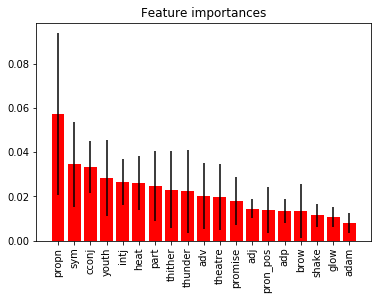

In [56]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[:-20:-1]


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), df.columns[indices],
          rotation='vertical')
plt.show()

In [61]:
lr = LogisticRegression(solver='liblinear')
train = lr.fit(X_train3, y_train3)
print('Training set score:', lr.score(X_train3, y_train3))
print('\nTest set score:', lr.score(X_test3, y_test3))

Training set score: 0.9677751997937613

Test set score: 0.9238205723124516


# TF-IDF

In [63]:
X_train2, X_test2, y_train, y_test = train_test_split(both_sents, 
                                                    sentences['author'],
                                                    test_size=0.4, 
                                                    random_state=0
                                                   )

vectorizer = TfidfVectorizer(max_df=0.5, # drop words that occur in more than half the paragraphs
                             min_df=2, # only use words that appear at least twice
                             stop_words='english', 
                             lowercase=True, #convert everything to lower case (since Alice in Wonderland has the HABIT of CAPITALIZING WORDS for EMPHASIS)
                             use_idf=True,#we definitely want to use inverse document frequencies in our weighting
                             norm=u'l2', #Applies a correction factor so that longer paragraphs and shorter paragraphs get treated equally
                             smooth_idf=True #Adds 1 to all document frequencies, as if an extra document existed that used every word once.  Prevents divide-by-zero errors
                            )


#Applying the vectorizer
sents_tfidf=vectorizer.fit_transform(both_sents)
print("Number of features: %d" % sents_tfidf.get_shape()[1])

#splitting into training and test sets
X_train_tfidf, X_test_tfidf= train_test_split(sents_tfidf, test_size=0.4, random_state=0)


#Reshapes the vectorizer output into something people can read
X_train_tfidf_csr = X_train_tfidf.tocsr()

#number of paragraphs
n = X_train_tfidf_csr.shape[0]
#A list of dictionaries, one per paragraph
tfidf_bypara = [{} for _ in range(0,n)]
#List of features
terms = vectorizer.get_feature_names()
#for each paragraph, lists the feature words and their tf-idf scores
for i, j in zip(*X_train_tfidf_csr.nonzero()):
    tfidf_bypara[i][terms[j]] = X_train_tfidf_csr[i, j]

#Keep in mind that the log base 2 of 1 is 0, so a tf-idf score of 0 indicates that the word was present once in that sentence.
print('Original sentence:', X_train2[3])
print('Tf_idf vector:', tfidf_bypara[3])

Number of features: 5660
Original sentence: yet with submiss approach and reverence meek , as to a superiour nature bow low , thus say .
Tf_idf vector: {'submiss': 0.42679482321111495, 'superiour': 0.37089580104179, 'meek': 0.37089580104179, 'reverence': 0.3753230689155395, 'approach': 0.32427357001188206, 'low': 0.28116179857955437, 'nature': 0.2776513389819742, 'bow': 0.3335503611512992, 'say': 0.17117233335958845}


In [18]:
sentences.head()

,text_sentences,author,words
0,"(THE, consulting, -, rooms, of, Dr, Orion, Hoo...",Chesterton,"[THE, consulting, rooms, of, Dr, Orion, Hood, ..."
1,"(In, such, a, place, the, sea, had, something,...",Chesterton,"[In, such, a, place, the, sea, had, something,..."
2,"(It, must, not, be, supposed, that, Dr, Hood, ...",Chesterton,"[It, must, not, be, supposed, that, Dr, Hood, ..."
3,"(These, things, were, there, ,, in, their, pla...",Chesterton,"[These, things, were, there, in, their, place,..."
4,"(Luxury, was, there, :, there, stood, upon, a,...",Chesterton,"[Luxury, was, there, there, stood, upon, a, sp..."


In [19]:
rfc = RandomForestClassifier(n_estimators=10)

train = rfc.fit(X_train_tfidf, y_train)

print('Training set score:', rfc.score(X_train_tfidf, y_train))
print('\nTest set score:', rfc.score(X_test_tfidf, y_test))

Training set score: 0.9896880639340037

Test set score: 0.8731631863882444


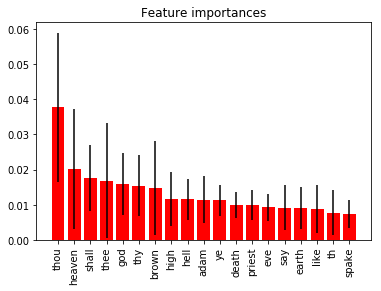

In [20]:
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[:-20:-1]


# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), np.array(vectorizer.get_feature_names())[indices],
          rotation='vertical')
plt.show()

# Include Punctuation

In [64]:
df_tfidf = pd.DataFrame(sents_tfidf.toarray(), columns=vectorizer.get_feature_names())
dftfidf = df.join(df_pos, lsuffix='_sent', rsuffix='_pos')
df_tfidf['author'] = Y

In [65]:
df_tfidf.head()

,aaron,abandon,abash,abdiel,abhor,abhorred,abide,abject,able,abnormal,...,yonder,young,youth,youthful,zeal,zenith,zephon,zephyr,zodiack,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
X4 = df_tfidf.drop('author', axis=1)
X_train4, X_test4, y_train4, y_test4 = train_test_split(X4,
                                                    Y, 
                                                    test_size=0.4, 
                                                    random_state=0)

lr = LogisticRegression(solver='liblinear')
train = lr.fit(X_train4, y_train4)
print('Training set score:', lr.score(X_train4, y_train4))
print('\nTest set score:', lr.score(X_test4, y_test4))

Training set score: 0.9688063934003609

Test set score: 0.9160866202629544


# TF-IDF and Bag of Words

In [26]:
Xt_bof = pd.DataFrame(X_train.toarray())
Xt_bof.head()

,0,1,2,3,4,5,6,7,8,9,...,1419,1420,1421,1422,1423,1424,1425,1426,1427,1428
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
Xt_tfidf = pd.DataFrame(X_train_tfidf.toarray())
Xt_tfidf.head()

,0,1,2,3,4,5,6,7,8,9,...,5650,5651,5652,5653,5654,5655,5656,5657,5658,5659
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
Xt = Xt_tfidf.join(Xt_bof, lsuffix='_tfidf', rsuffix='_bof')

In [35]:
Xtest_bof = pd.DataFrame(X_test.toarray())
Xtest_tfidf = pd.DataFrame(X_test_tfidf.toarray())

Xtest_combined = Xtest_tfidf.join(Xtest_bof, lsuffix='_tfidf', rsuffix='_bof')

In [37]:
rfc = RandomForestClassifier(n_estimators=10)

train = rfc.fit(Xt, y_train)

print('Training set score:', rfc.score(Xt, y_train))
print('\nTest set score:', rfc.score(Xtest_combined, y_test))

Training set score: 0.9909770559422532

Test set score: 0.8615622583139985


# Bag of Words and Punctuation Logistic Regression Scoring the Best